In [1]:
import numpy as np
from pysrc.optimization import gams, gurobi
from pysrc.sampling import baseline
from pysrc.services.data_service import load_site_data
from pysrc.analysis import value_decomposition

/Users/ph2696/Projects/project-amazon/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model scenario

In [2]:
opt = "gurobi"
pee = 7.1
pa = 41.11
b = 25
sitenum = 78
T = 200
h = 50

## Solve model

In [3]:
# Load site data
(
    zbar_2017,
    z_2017,
    forest_area_2017,
    _,
    _,
    _,
    _,
) = load_site_data(sitenum)

# Set productivity parameters using baseline mean
baseline_fit = baseline.sample(
    num_sites=sitenum,
    iter_sampling=10**4,
    chains=5,
    seed=1,
)

theta = baseline_fit.stan_variable("theta").mean(axis=0)
gamma = baseline_fit.stan_variable("gamma").mean(axis=0)

# Computing carbon absorbed in start period
x0_vals = gamma * forest_area_2017

# Choose optimizer
if opt == "gurobi":
    solve_planner_problem = gurobi.solve_planner_problem

elif opt == "gams":
    solve_planner_problem = gams.solve_planner_problem

else:
    raise ValueError("Optimizer must be one of ['gurobi', 'gams']")

results = solve_planner_problem(
    T=T + h,
    theta=theta,
    gamma=gamma,
    x0=x0_vals,
    zbar=zbar_2017,
    z0=z_2017,
    pe=pee + b,
    pa=pa,
)

Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/hmc


10:46:08 - cmdstanpy - INFO - compiling stan file /Users/ph2696/Projects/project-amazon/stan_model/baseline.stan to exe file /Users/ph2696/Projects/project-amazon/stan_model/baseline


Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/hmc


10:46:13 - cmdstanpy - INFO - compiled model executable: /Users/ph2696/Projects/project-amazon/stan_model/baseline
10:46:13 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status











chain 1 |▉         | 00:00 Iteration:  800 / 10000 [  8%]  (Sampling)

chain 1 |█▉        | 00:00 Iteration: 1900 / 10000 [ 19%]  (Sampling)






chain 1 |██▊       | 00:00 Iteration: 3000 / 10000 [ 30%]  (Sampling)


chain 1 |███▊      | 00:00 Iteration: 4100 / 10000 [ 41%]  (Sampling)





chain 1 |█████     | 00:00 Iteration: 5400 / 10000 [ 54%]  (Sampling)





chain 1 |█████▉    | 00:00 Iteration: 6500 / 10000 [ 65%]  (Sampling)








chain 1 |███████▏  | 00:00 Iteration: 7800 / 10000 [ 78%]  (Sampling)


chain 1 |████████▍ | 00:00 Iteration: 9200 / 10000 [ 92%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                        
chain 2 |██████████| 00:00 Sampling completed                        
chain 3 |██████████| 00:00 Sampling completed      


10:46:14 - cmdstanpy - INFO - CmdStan done processing.



Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmp8sj0l0r_.pyomo.lp
Reading time = 0.11 seconds
x1: 39250 rows, 78251 columns, 195016 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 39250 rows, 78251 columns and 195016 nonzeros
Model fingerprint: 0x6077a2fe
Model has 250 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [4e-03, 6e+03]
  QObjective range [1e+03, 2e+05]
  Bounds range     [3e-04, 1e+00]
  RHS range        [6e-07, 7e+00]
Presolve removed 19502 rows and 19504 columns
Presolve time: 0.03s
Presolved: 19748 rows, 58747 columns, 117165 nonzeros
Presolved model has 250 quadratic objective terms
Ordering time: 0.01s

Barrier sta

In [4]:
results["w"].shape

(251,)

In [5]:
value_decomposition(
    Z=results["Z"],
    X=results["X"],
    U=results["U"],
    V=results["V"],
    T=T+h,
    pee=pee,
    pa=pa,
    b=b,
    theta=theta,
)

{'pa': 41.11,
 'pee': 7.1,
 'b': 25,
 'total_AO': 17.401173734286726,
 'total_NT': 352.8130650327535,
 'total_FS': 100.19891046930198,
 'total_AC': 26.966996492524096,
 'total_PV': 443.44615274381806}

In [6]:
V = [
    value_decomposition(
        Z=results["Z"][t:],
        X=results["X"][t:],
        U=results["U"][t:],
        V=results["V"][t:],
        T=T,
        pee=pee,
        pa=pa,
        b=b,
        theta=theta,
    )["total_PV"]
    for t in range(h)
]

<function matplotlib.pyplot.show(close=None, block=None)>

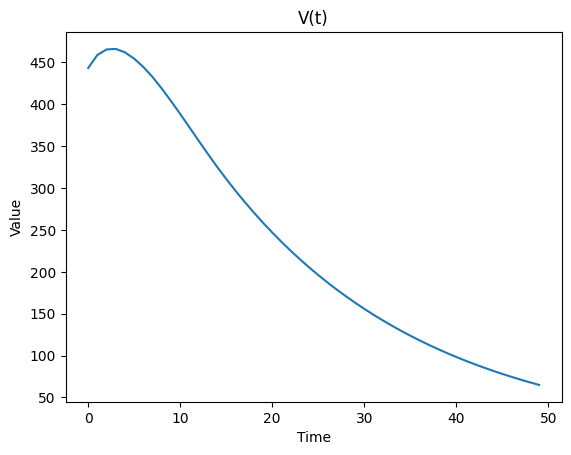

In [8]:
import matplotlib.pyplot as plt

# Plotting the line plot
plt.plot(V)

# Adding labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("V(t)")

# Displaying the plot
plt.show

In [9]:
W = []
for t in range(h):
    defection = solve_planner_problem(
        T=T,
        theta=theta,
        gamma=gamma,
        x0=results["X"][t],
        zbar=zbar_2017,
        z0=results["Z"][t],
        pe=pee,
        pa=pa,
    )

    W.append(
        value_decomposition(
            Z=defection["Z"],
            X=defection["X"],
            U=defection["U"],
            V=defection["V"],
            T=T,
            pee=pee,
            pa=pa,
            b=0,
            theta=theta,
        )["total_PV"]
    )

Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmp8lfwvrym.pyomo.lp
Reading time = 0.08 seconds
x1: 31400 rows, 62601 columns, 155966 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 31400 rows, 62601 columns and 155966 nonzeros
Model fingerprint: 0x50fdcf34
Model has 200 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-03, 1e+03]
  QObjective range [3e+03, 2e+05]
  Bounds range     [3e-04, 1e+00]
  RHS range        [6e-07, 7e+00]
Presolve removed 15602 rows and 15604 columns
Presolve time: 0.02s
Presolved: 15798 rows, 46997 columns, 93715 nonzeros
Presolved model has 200 quadratic objective terms
Ordering time: 0.00s

Barrier stati

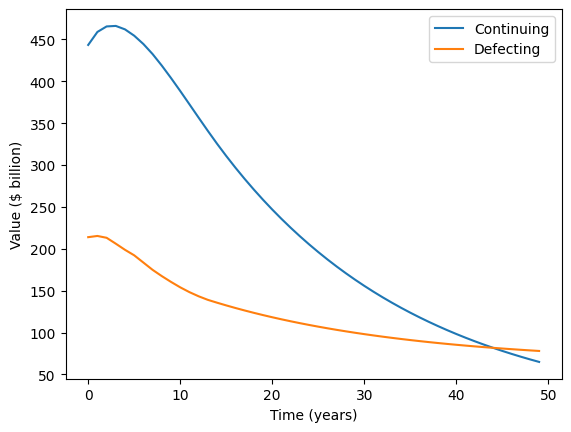

In [14]:
# Plotting the line plots for V and W
plt.plot(V, label="Continuing")
plt.plot(W, label="Defecting")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Value ($ billion)")
#plt.title("Value under b=$25 scheme v.s defecting")

# Displaying the plot
plt.show()

## Time and value of defecting

In [11]:
def defect_time(V, W):
    indices = [i for i, (v, w) in enumerate(zip(V, W)) if v < w]
    return indices[0] if indices else -1

In [12]:
defect_time(V, W)

45

## Maximum gap between $V(t)$ and $W(t)$

In [ ]:
abs(min([V[i] - W[i] for i in range(h)]))

In [ ]:
abs(min([V[i] - W[i] for i in range(h)])) / (1.02 ** (h))

In [ ]:
[(V[i] - W[i])/ (1.02 ** i) for i in range(h)]

## Analysing gap

In [ ]:
gap = [max(W[i] - V[i], 0) for i in range(h)]

# Plotting the line plots for V and W
plt.plot(gap, label="max{W(t)-V(t), 0}")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("Additional payoff from defecting")

# Displaying the plot
plt.show()

In [ ]:
PV_gap = [max(W[t] - V[t], 0) / (1.02 ** (t)) for t in range(h)]

# Plotting the line plots for V and W
plt.plot(PV_gap, label="max{W(t)-V(t), 0} / (1+δ)^t")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("Present value for additional payoff from defecting")

# Displaying the plot
plt.show()

In [ ]:
PV_gap[49]